<a href="https://colab.research.google.com/github/bingsen-wang/Electric-Machines/blob/main/Simulation_InductionMachine_SyRF_LineStart_anim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Simulation: Induction Line Start in Synchronous Reference Frame</h1></b>

Dr. Bingsen Wang

7/13/2025
</center>

In synchronous reference frame, the dynamic equations in matrix form are
$$
\underbrace{\left[\begin{array}{cc}L_s & L_m \\ L_m & L_r\end{array}\right]}_{A}
\begin{bmatrix}{d\underline i_s\over dt}\\ {d\underline i_r\over dt}\end{bmatrix}
= \underbrace{\begin{bmatrix}-R_s-j\omega_s L_s & -j\omega_s L_m \\
-j(\omega_s - \omega_r) L_m & -R_r -j(\omega_s - \omega_r) L_r\end{bmatrix}}_{B}
\begin{bmatrix}\underline i_s\\
\underline i_r\end{bmatrix}
+ \begin{bmatrix}\underline v_s\\ \underline v_r\end{bmatrix}
\tag{1}$$

#Python Code

0
0
100
200
300
400
500
600
0


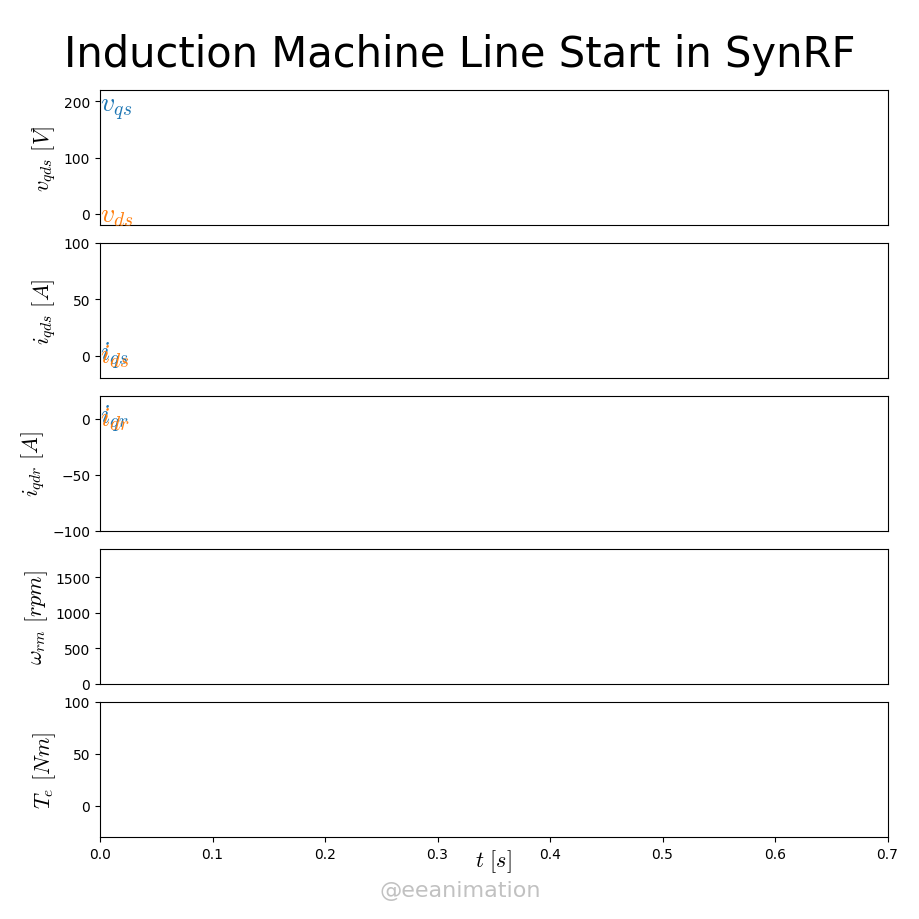

In [38]:
from matplotlib import pyplot,animation,cm
import numpy as np; from scipy.integrate import odeint
pyplot.rcParams.update({"font.family":"sans-serif", "mathtext.fontset":"cm"})

c2ir =lambda c: list(np.array(c).real)+list(np.array(c).imag)
vs=lambda t,Vll_rms,ws: np.sqrt(2/3)*Vll_rms+t*0 #constant in SyRF
def indM(x,t,rs,rr,Ls,Lr,Lm,Npp,Vll_rms,ws,J,T1): #induction machine model
  isr,wrm=[x[0]+1j*x[2],x[1]+1j*x[3]],x[4]; wr=wrm*Npp
  A=np.array([[Ls,Lm],[Lm,Lr]]); Ainv=np.linalg.inv(A)
  B=np.array([[-rs-1j*ws*Ls,-1j*ws*Lm],[-1j*(ws-wr)*Lm,-rr-1j*(ws-wr)*Lr]])
  Te=3/2*Npp*Lm*(isr[0]*np.conj(isr[1])).imag
  didt=Ainv@B@isr+Ainv@[vs(t,Vll_rms,ws),0]; dwrm=Te/J #dynamic equations
  return [*c2ir(didt),dwrm,Te,*isr]
sys=lambda x,t,*args: indM(x,t,*args)[:5] #machine model wrapper

#Parameters
rs,rr = 0.531,0.408; Lls=Llr = 2.52e-3;Lm = 84.7e-3;Npp = 2; J = 0.1
Vll_rms=230; ws = 2*np.pi*60; t_start=0; t_step=1e-3; t_end=.7;
args=(rs,rr,Lls+Lm,Llr+Lm,Lm,Npp,Vll_rms,ws,J,t_end)

#simulation by odeint
x0=np.array([0,0,0,0,0]); t=np.arange(t_start,t_end,t_step)
x_sol=odeint(sys,x0,t,args=args)
Te,is_sv,ir_sv=[[indM(x_sol[k,:],t[k],*args)[5+i] for k in range(len(t))] for i in range(3)]
vqds=vs(t,Vll_rms,ws).real,-vs(t,Vll_rms,ws).imag #d-axis in negative Imag
iqds,iqdr=[np.array(is_sv).real,-np.array(is_sv).imag],[np.array(ir_sv).real,-np.array(ir_sv).imag]

cl = list(cm.tab10.colors) #colors of lines
fig = pyplot.figure(figsize=([9,9])); ax=fig.add_axes([0,0,1,1],xlim=[0,1]);ax.axis('off')
ax.text(.5,.95,r"Induction Machine Line Start in SynRF",size=30,ha='center',va='center')
axs = [fig.add_axes([.1,.08+(4-k)*.17,.875,.15],xlim=[0,t_end],fc='none') for k in range(5)]
[axs[k].set_xticks([]) for k in range(4)]; axs[4].set_xlabel('$t\ [s]$',size=16,labelpad=-10)
[axs[k].set_ylabel([r'$v_{qd s}\ [V]$',r'$i_{qd s}\ [A]$',r'$i_{qd r}\ [A]$',r'$\omega_{rm}\ [rpm]$',r'$T_e\ [Nm]$'][k],size=16)for k in range(5)]
[axs[k].set_ylim([[-20,220],[-20,100],[-100,20],[0,1900],[-30,100]][k]) for k in range(5)]
lines=[axs[k].plot([],[],c=cl[i],lw=2)[0] for k in range(3) for i in range(2)]
lines+=[axs[3].plot([],[],c=cl[3],lw=2)[0]]+[axs[4].plot([],[],c=cl[k],lw=2)[0] for k in range(2)]
txts=[axs[k].text(0,0,[['$v_{qs}$','$v_{ds}$'],['$i_{qs}$','$i_{ds}$'],
 ['$i_{qr}$','$i_{dr}$']][k][i],c=cl[i],size=20,va='center') for k in range(3) for i in range(2)]

def update(i):
  if i%100==0: print(i) #for monitoring
  [lines[k+2*kk].set_data(t[:i+1],[vqds,iqds,iqdr][kk][k][:i+1]) for kk in range(3) for k in range(2)]
  [txts[k+2*kk].set_position((t[i],[vqds,iqds,iqdr][kk][k][i])) for kk in range(3) for k in range(2)]
  [lines[6+k].set_data(t[:i+1],[x_sol[:i+1,4]*60/(2*np.pi),Te[:i+1]][k])for k in range(2)]
  return
ax.text(np.average(ax.get_xlim()),ax.get_ylim()[0]*.99+ax.get_ylim()[1]*.01,r'@eeanimation',size=16,c='.2',alpha=.3,ha='center',va='bottom')
anim = animation.FuncAnimation(fig, update, frames=len(t))
anim.save("inductionMotor2Generator_SynRF_start.mp4",writer=animation.FFMpegWriter(fps=60),dpi=200)